In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.special import logsumexp
import multiprocessing
import time

In [2]:
print("Starting time:", time.ctime())

Starting time: Sat Sep 11 03:01:57 2021


# Evaluating the Parisi formula for a pure p-spin glass

The goal here is to calculate the zero-temperature Parisi constant, and compare it to the maximum satisfying fraction of randomXORSAT instances.

## Using the Parisi formula

Wei-Kuo Chen says:
> I am not aware of numerical simulations for the Parisi constant P(K) for large K. Nevertheless, this constant can be written as the Parisi formula, which is a convex optimization problem (see Theorem 1 in https://arxiv.org/pdf/1606.05335.pdf). With this, it should be fairly easy to run a numerical simulation to approximate P(K) for large K.


Paraphrased from the linked paper:
> We introduce the space $U$ that collects all nonnegative and nondecreasing functions $f$ on $[0,1)$ that are right continuous and satisfy $\int_0^1 f(t)dt < \infty$. Let's say $f$ has $k$ jumps. Then it has value $m_i$ in region $[q_i,q_{i+1})$, given $q_0 = 0$ and $q_{k+1} = 1$, where $m_i$ and $q_i$ are increasing and nonnegative. The distance metric $d$ is the integral of $f$, or equivalently, $d = \sum_{i=0}^k m_i(q_{i+1} - q_i)$.

$P(f) = \Psi_f(0, h) - 0.5 \int_0^1 t \xi^{''}(t)f(t) dt$

$\xi(s) =\sum_{p\ge 2} c_p^2 s^p$ Where the $c_p$'s are the mixing constants (mixed vs pure spin glasses).

$\partial_t \Psi_f(t,x) = -0.5\xi^{''}(t) 
\Big(
\partial_x^2 \Psi_f(t,x) + f(t) (\partial_x \Psi_f(t,x))^2
\Big)$

With boundary condition: $\Psi_f(1,x) = |x|$.

This can be solved recursively, by using the transformation $f(t) \Psi = \log \Phi$ for a piecewise, continuous function $f$.

This is the coefficient $a_{\ell} = \sqrt{ \xi^{'}(q_{\ell+1}) - \xi^{'}(q_{l}) }$

In [3]:
global grid

In [4]:
def a(qs, l, xiprime):
    return (xiprime(qs[l+1]) - xiprime(qs[l]))**0.5

Let $\Psi_{k+1}(x) = abs(x)$.

For $1\le \ell \le k$, let $Exp(m_{\ell} \Psi_{\ell}(x)) = \mathbb{E}[Exp(m_{\ell} \Psi_{\ell+1}(x + a_{\ell} z) ]$, for standard Gaussian variable $z$.

Let $\Psi_0(x) = \mathbb{E}[\Psi_{\ell+1}(x + a_{0} z)]$, since I let $m_0 = 0$.

In [5]:
def psi0(qs, ms, xiprime, k, PDF_INPS):
    a_s = np.array([a(qs, l, xiprime) for l in range(len(qs)-1)])
    start = 0
    for i in range(len(grid)):
        start += a_s[i]*grid[i]
    start =  np.abs(start)
    # 1 to k
    for i in list(range(1, k+1))[::-1]:
        start = np.log(np.sum(np.exp(ms[i]*start)*PDF_INPS, axis=i))/ms[i]
        # scipy is slower
        #  start = logsumexp(ms[i]*start, b=PDF_INPS, axis=i)/ms[i]
    # 0
    start = np.sum(PDF_INPS*start, axis=0)
    return start

The penalty term in the operator is $0.5 \int_0^1 f(t)  t \xi^{''}(t) dt = 0.5 \sum_{i=0}^k \int_{q_i}^{q_{i+1}} m_i t \xi^{''}(t) dt$

In [6]:
def penalty(qs, ms, xiprimeprime, k):
    out = 0
    for i in range(k+1):
        integral = quad(lambda t: t * xiprimeprime(t), qs[i], qs[i+1])[0]
        out += ms[i] * integral
    return 0.5 * out

This tests the ground state energy of inputs **m**, **q**:

In [7]:
def make_test(xiprime, xiprimeprime, k, PDF_INPS):
    # the input here is a list of "adjustments" 
    # (m_1, m_2-m_1, ...,m_k-m_{k-1}, q_1, q_2-q_1,...,q_k-q_{k-1})
    def test(inp):
        assert len(inp) == 2*k
        inp_qs,inp_ms= inp[:k],inp[k:]

        # if bad input, return a large number
        if np.any(np.array(inp) < 0) or sum(inp_ms) > 2 or sum(inp_qs) > 1:
            return 10000

        qs = np.array([0,*[sum(inp_qs[:i+1]) for i in range(k)],1])
        ms = np.array([0,*[sum(inp_ms[:i+1]) for i in range(k)]])
        output =  psi0(qs, ms, xiprime, k, PDF_INPS) - penalty(qs, ms, xiprimeprime, k)
        return output
    return test

## Evaluating the Parisi formula

In [8]:
# set parameters
# k is number of jumps
k=2
# if this range is too small, it fails at higher p
INPS = np.linspace(-20,20,250)
PDF_INPS = stats.norm.pdf(INPS)
PDF_INPS = PDF_INPS/np.sum(PDF_INPS)
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)
grid = np.meshgrid(*[INPS]*(k+1), indexing='ij')

In [9]:
# pure p-spin model; p=2 is SK model
ps = range(2, 35)
# if C_psq is too low, my convergence is not very good.
C_psq = 2

def run(P):
#     xi = lambda x: x**P * C_psq
    xiprime = lambda x: P * (x**(P-1)) * C_psq
    xiprimeprime = lambda x: P * (P-1) * (x**(P-2)) * C_psq
    opt = minimize(make_test(xiprime, xiprimeprime, k, PDF_INPS), 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
    print("p:", P, opt.fun)
    return {"x": opt.x, "fun": opt.fun}

In [10]:
%%time
print("kXOR:")
r = []
for P in ps:
    r.append(run(P))

kXOR:
1.5766702154956154
1.5766702154956154
1.5766702154956154
1.5304313341590552
1.5403919157610084
1.5299517572030412
1.529891097052519
1.5298910427971335
1.5298910336087386
1.5298910331276525
1.5298910323108919
1.5298910323108919
1.529891032310892
1.5298910323108919
1.5298910323108919
1.5330335609126626
1.5311070737956052
1.5307374127907507
1.5295342921776673
1.5295341531764968
1.5295341522593588
1.5295341329442427
1.5297098423214053
1.5295341209761701
1.5295342813904118
1.5295341806952703
1.5295341251270649
1.5295341458443423
1.5295341184939475
1.529534118463045
1.5295341168114247
1.529534116975296
1.529534116312174
1.5295341161838194
1.5295341161381517
1.5295341160041693
1.529534116034736
1.5295341159917264
1.5295341160381049
1.5295341159998634
1.5295341159902787
1.5295341159875673
1.5295341159900318
1.5295341159872178
1.5295341159865599
1.5295341159874334
1.529534115986505
1.529534115986504
1.5295341159863498
1.5295341159864047
1.5295341159863196
1.5295341159863196
1.624985498647

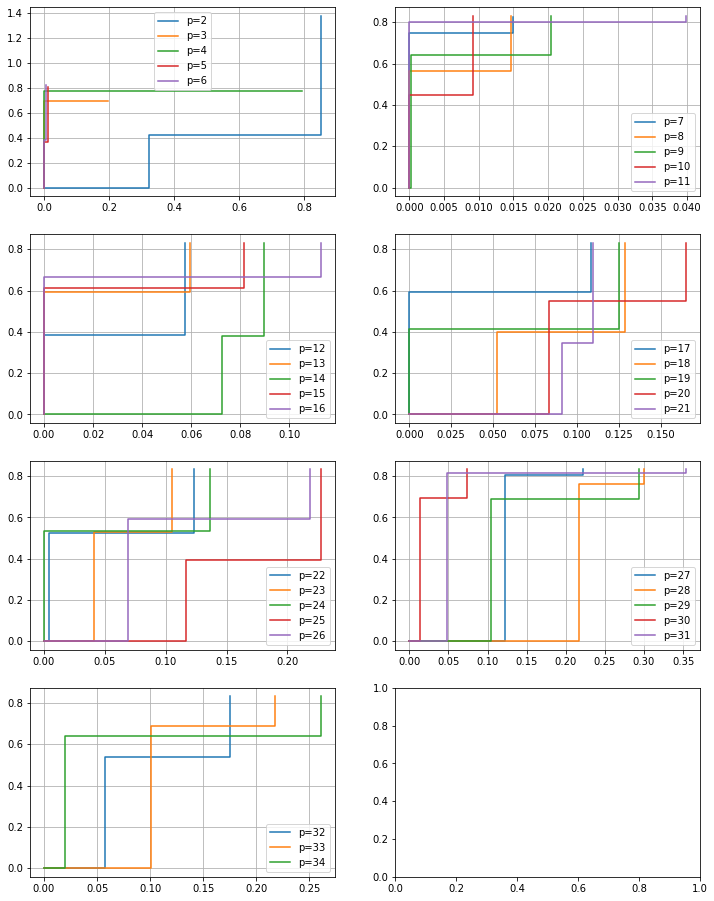

In [11]:
num_vert_plots = int(np.ceil(len(ps)/10))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))

for idx in range(len(r)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()

    qs = np.array([0,*[sum(r[idx]['x'][:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(r[idx]['x'][k:][:i+1]) for i in range(k)]])
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()

I notice that the locations of the symmetry breaking points are often at very low values.  This may be related to the Auffinger Chen Zeng result that perturbing a solution to this variational near $1$ will reduce the energy. So perhaps perturbations very close to $0$ can also reduce the energy: https://doi.org/10.1002/cpa.21886

## Finding the large-p limit

Let's look at the constants after dividing out by $c_p$:

In [12]:
outs = np.array([i['fun'] for i in r])
outs_scaled = np.array(outs)* C_psq**-0.5

In [32]:
0.763168*2**0.5

1.0792825359691502

In [13]:
for p, x in zip(ps, outs_scaled):
    print(p, x)

2 1.0799046776296093
3 1.1504979356603595
4 1.1673118289789624
5 1.1733107599296182
6 1.1756198730642813
7 1.176600866514827
8 1.1770362039452995
9 1.1772348224039837
10 1.1773271020865503
11 1.1773705050338144
12 1.1773910941212915
13 1.1774009210931677
14 1.1774056329293956
15 1.177407900180479
16 1.1774089942449855
17 1.177409523428635
18 1.177409779897808
19 1.1774099044102764
20 1.1774099649511938
21 1.1774099944273686
22 1.1774100087961363
23 1.1774100158081844
24 1.177410019233523
25 1.1774100209083118
26 1.17741002172786
27 1.1774100221292283
28 1.177410022325922
29 1.177410022422381
30 1.1774100224697248
31 1.1774100224929547
32 1.17741002250437
33 1.177410022509982
34 1.1774100225127428


In [14]:
guess = (2*np.log(2))**0.5

In [15]:
print(guess)

1.1774100225154747


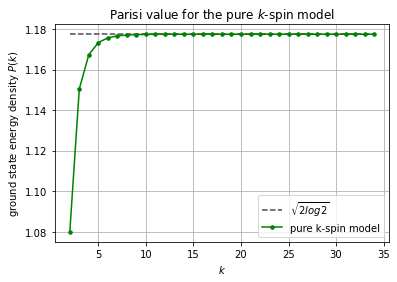

In [16]:
plt.plot(ps, [guess]*len(ps), 'b--', 
         color='black', label="$\sqrt{2 log 2}$", alpha=0.7)
plt.plot(ps, outs_scaled, 'g.-', ms=7,label="pure k-spin model")
plt.xlabel("$k$")
plt.ylabel("ground state energy density $P(k)$")
plt.title("Parisi value for the pure $k$-spin model")
plt.grid()
plt.legend()
plt.savefig('images/parisi_value.png', dpi=300)

## Relationship with $c_{p}$

I ran the above several times for different $c_p$. 
The asymptotic value seems to depend on the constant I use. If $c_p^2 < 2 log(2)$, The energy is $log(2) + c_p^2 / 2$. Otherwise, the energy is $\sqrt{ 2 c_p^2 log(2)}$.

Text(0, 0.5, '$energy / C_p$')

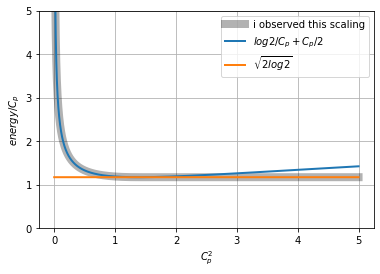

In [17]:
# this is what I observed after running for many different c_p^2
inps = np.linspace(1e-10, 5, 100000)
f1 = lambda x: x**-0.5 * (np.log(2) + x/2)
f2 = lambda x: x**-0.5 * (2 * x * np.log(2))**0.5

plt.plot(inps, [f1(i) if i < 2*np.log(2) else f2(i) for i in inps], 
         label='i observed this scaling',
         linewidth=8, alpha=0.3, color='black')
plt.plot(inps, f1(inps), label='$log 2/C_p +C_p/2$', linewidth=2)
plt.plot(inps, f2(inps), label='$\sqrt{2 log 2}$', linewidth=2)
# plt.plot(inps, inps**0.5, label='sqrt(x) (expected scaling)', linewidth=2)
plt.legend()
plt.grid()
plt.ylim(0,5)
plt.xlabel('$C_p^2$')
plt.ylabel("$energy / C_p$")

The minimum energy should be proportional to $c_p$. I think this means the limit of $P(p)$ is in fact $\sqrt{2 log 2}$.

This ended up being true, because of the relationship to the random energy model.

## Comparison with Montanari for Max 2XOR, Max 3XOR

This also roughly matches the calculation in https://arxiv.org/pdf/2009.11481.pdf that does Max 2XOR and Max 3XOR. They get
$$
e_2 = 0.763168\pm 0.000002
$$
and 
$$
e_3 = 0.8132\pm 0.0001
$$

Where $e_2$ uses $\xi(s) = s^2/2$ and $e_3$ uses $\xi(s) = s^3/2$.

In [18]:
for p, o in list(zip(ps, outs_scaled))[:2]:
    print("my result, p:", p, "e_p:", o * 2**-0.5)

my result, p: 2 e_p: 0.7636079205869694
my result, p: 3 e_p: 0.8135248920465645


/The agreement gives me confidence that my approach is correct.

Note: This matches Table 1 in the original Parisi paper! (k=0 -> 0.798, k=1 -> 0.7652, k=2 -> 0.7636)

One way to improve my precision is to explicitly solve for the derivative, and use it in the optimization procedure (as the Montanari paper does).

## Using the Parisi constants in Sen's Max XOR upper bound

I insert these values for Subhabrata Sen's bounds for Max XOR on hypergraphs, as listed here: https://doi.org/10.1002/rsa.20774

The satisfying fraction for Max CUT on p-uniform hypergraphs is to first order in D: $\frac{1}{2}+ \frac{P_p \sqrt{p}}{2}\frac{1}{\sqrt{D}}$

This makes the satisfying fraction $\frac{1}{2} + \frac{C_p}{\sqrt{D}}$, where $C_p$ is listed below:

In [19]:
for p, x in zip(ps, outs_scaled):
    print(p, x * p**0.5 / 2)

2 0.7636079205869694
3 0.9963604392834259
4 1.1673118289789624
5 1.3118013089672813
6 1.4398344102415093
7 1.5564966425906686
8 1.664580563023587
9 1.7658522336059757
10 1.8615175968195377
11 1.9524481022142028
12 2.039301195397187
13 2.1225896963899733
14 2.2027242418397606
15 2.28004059454602
16 2.354817988489971
17 2.4272919148522067
18 2.4976633188033013
19 2.56610539422414
20 2.6327687190165143
21 2.697785211730475
22 2.7612712305156206
23 2.823330034838509
24 2.8840537651626588
25 2.9435250522707794
26 3.001818338145031
27 3.059000969502929
28 3.1151341102293975
29 3.1702735081582265
30 3.224470143696664
31 3.2777707818375834
32 3.3302184445993825
33 3.381852817485171
34 3.432710600890263


Because of the limit, we expect a large $p$XORSAT problem to have satisfying fraction at most

$$\frac{1}{2} + \frac{\sqrt{2 log 2}}{2} \sqrt{\frac{p}{D}} = \frac{1}{2} + \sqrt{\frac{p log 2}{2}} \frac{1}{\sqrt{D}} \approx \frac{1}{2} + 0.58871\sqrt{\frac{p}{D}}$$

## Bonus: Evaluating the $p$-SAT approximations

A similar formula to Sen has been done by Panchenko for $p$-SAT: https://arxiv.org/pdf/1608.06256.pdf

Given $N$ variables and $\alpha N$ clauses, the satisfying fraction is 
$$1-\frac{1}{2^p} + \frac{B_p}{2^p}\frac{1}{\sqrt{\alpha}}$$

Where $B_p$ is the limit of a Parisi formula with $\xi(x) = (1+x)^p - 1$.

In [20]:
# set parameters
# k is number of jumps
k=2
# if this range is too small, it fails at higher p
INPS = np.linspace(-30, 30, 250)
PDF_INPS = stats.norm.pdf(INPS)
PDF_INPS = PDF_INPS/np.sum(PDF_INPS)
assert np.allclose(sum(PDF_INPS),1), sum(PDF_INPS)
grid = np.meshgrid(*[INPS]*(k+1), indexing='ij')

In [21]:
ksat_ps = range(3, 10)

# CONST_SQ may affect my convergence.
CONST_SQ = 0.5

def run_ksat(P):
#     xi = lambda x: CONST_SQ* (-1 + (1+x)**P)
    xiprime = lambda x: CONST_SQ* P * ((1+x)**(P-1))
    xiprimeprime = lambda x:CONST_SQ* P * (P-1) * ((1+x)**(P-2))
    opt = minimize(make_test(xiprime, xiprimeprime, k, PDF_INPS), 
                       [np.random.random()/k for _ in range(2*k)], 
                       method='Powell', 
                       options={"xtol": 1e-10, "ftol":1e-14}
                      )
    print("p:", P, opt.fun)
    return {"x": opt.x, "fun": opt.fun}

In [22]:
%%time

print("kSAT:")
r_ksat = []
for P in ksat_ps:
    r.append(run_ksat(P))
# pool = multiprocessing.Pool(processes=n_proc)
# r_ksat = pool.map(run_ksat, ksat_ps)
# pool.close()

kSAT:
1.5919233302125013
1.5919233302125013
1.5919233302125013
1.6391867080420717
1.6102474730806509
1.5831334046262522
1.5850645204219105
1.5837221378264135
1.5833329246305894
1.5832078759209303
1.5831616801446533
1.5831457063564396
1.583123243123318
1.5831161635370037
1.5831115059162317
1.5831136353622373
1.5831124811611024
1.5831116175176045
1.5831117208913348
1.5831116102533416
1.5831115408052987
1.5831115276632661
1.5831115092279955
1.5831115006151508
1.5831114999368987
1.583111496393042
1.5831114969135411
1.5831114958831827
1.5831114963575963
1.5831114956690628
1.5831114955451562
1.5831114954939896
1.5831114953827579
1.5831114954260004
1.5831114953827579
1.5831114953827579
1.5945449935972338
1.5868414172952523
1.5824450662026643
1.5817087032157928
1.5811498654957967
1.581254260292703
1.5811246057124277
1.581143397140015
1.5811857754256438
1.5811488373374594
1.5811246320437
1.5811246267396557
1.5811295571203519
1.581125907489033
1.5811244973650043
1.5811250770297316
1.581124527890

/tmp/ipykernel_54161/3977490124.py:9: RuntimeWarning: overflow encountered in exp
  start = np.log(np.sum(np.exp(ms[i]*start)*PDF_INPS, axis=i))/ms[i]


inf
10.397965269815371
12.436858641533199
10.790628171655932
10.314286363914459
10.304192632612992
10.303406851283079
10.303404087154089
10.303404023054672
10.303404023040343
10.303404023040347
10.303404023040347
10.303404023040343
10.303404023040343
10.303404023040343
10.30340402304034
10.303404023040343
10.303404023040343
10.30340402304034
inf
10.30340402304034
11.461073098889045
10.866732570445656
9.897223927492197
9.962302590515812
9.90189492322039
9.893839311831346
9.893656923565013
9.893655892461421
9.89365582626391
9.893655826248803
9.893655826248793
9.893655826248791
9.893655986276883
9.893655849594236
9.893655829655273
9.893655826746027
9.893655826321428
9.893655826259424
9.893655826250356
9.893655826249027
9.893655826248832
9.893655826248796
9.893655826248796
9.893655826248793
9.893655826248791
9.893655826248791
9.400846934742251
9.42485424541957
9.405135491817568
9.40113666903102
9.400360038186244
9.400086285505658
9.400188126235053
9.400025811030778
9.400048436806198
9.4000

In [24]:
r_ksat = r

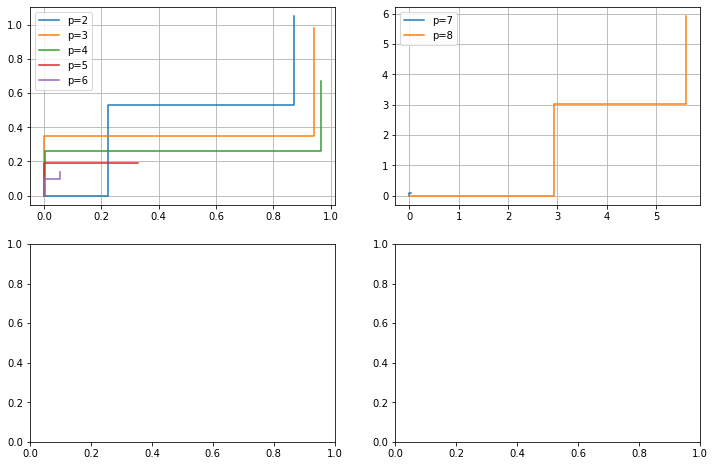

In [25]:
num_vert_plots = int(np.ceil(len(ksat_ps)/5))
fig, axs = plt.subplots(num_vert_plots, 2, figsize=(12, 4*num_vert_plots))

for idx in range(len(r_ksat)):
    P = ps[idx]
    if idx % 5 == 0:
        ax = axs[idx // 10, (idx % 10)//5]
        ax.grid()

    qs = np.array([0,*[sum(r[idx]['x'][:k][:i+1]) for i in range(k)]])
    ms = np.array([0,*[sum(r[idx]['x'][k:][:i+1]) for i in range(k)]])
    ax.step(qs, ms, where='post', label="p=" + str(P))
    if idx % 5 == 4:
        ax.legend()

ax.legend()

The constants after reducing by CONST_SQ (to help with convergence):

In [26]:
outs = np.array([i['fun'] for i in r_ksat])
ksats_scaled = outs * CONST_SQ**-0.5

In [27]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o)

3 2.2183895861627168
4 3.749883280700866
5 5.8437284039193935
6 8.73438786556379
7 12.749771109771029
8 18.363882166718113
9 14142.135623730952


I calculate $C$, where the satisfying fraction is $1-1/2^p + C/\sqrt{\alpha}$:

In [29]:
for p,o in zip(ksat_ps, ksats_scaled):
    print(p, o*2**(-p))

3 0.2772986982703396
4 0.23436770504380414
5 0.18261651262248105
6 0.1364748103994342
7 0.09960758679508616
8 0.07173391471374263
9 27.621358640099515


It would be nice to get a confirmation on this constant, but I haven't seen it calculated anywhere.

In [ ]:
print("Ending time:", time.ctime())